# **SemEval 2015 Task 12**

In [ ]:
!pip install transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import os
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 encoder = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
encoder(slow_tokenizer("hello how are you", return_tensors="tf"))['last_hidden_state'][0]

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[ 3.5377089e-02,  4.9712881e-03, -1.6398986e-01, ...,
        -2.9469514e-01,  1.0046009e-01,  2.6906958e-01],
       [ 1.9154608e-01,  1.5503927e-01,  3.9772588e-01, ...,
        -6.0796332e-01,  5.2366585e-01, -2.5391939e-01],
       [-3.5802642e-01, -6.1634368e-01,  4.8258886e-02, ...,
        -2.8904155e-04,  7.1064633e-01, -6.0931194e-01],
       [ 4.1431257e-01, -1.3597898e+00,  1.8618979e-01, ...,
        -4.9402261e-01,  4.3869135e-01, -3.7817371e-01],
       [-2.7346632e-01, -1.2541181e+00,  3.3194888e-01, ...,
        -5.6550704e-02,  3.8558537e-01, -5.8725363e-01],
       [ 5.2414024e-01, -2.5613758e-01, -3.2033288e-01, ...,
         4.1231364e-01, -3.8296321e-01, -2.1611504e-01]], dtype=float32)>

# Dataset

In [ ]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
# !pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTR.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("./dataset")

**Dataset creation**

In [ ]:
import numpy as np
xml_path = "/content/dataset/ABSA15_RestaurantsTrain/ABSA-15_Restaurants_Train_Final.xml"
mytree = ET.parse(xml_path)
reviews = mytree.getroot()
rows_list = []
for rew in reviews:
  rid = rew.attrib['rid']
  for sent in rew[0]: #cicle on single sentence in review.
    sid = sent.attrib['id']
    txt = sent[0].text
    if len(sent)>1:
      row_dict = {}
      row_dict['rid'] = rid # Review id
      row_dict['sid'] = sid # Sentence id
      row_dict['txt'] = txt
      row_dict['OOTS'] = False
      row_dict['f'] = 'yes'
      for opinion in sent[1]:
        op_dict = opinion.attrib
        rows_list.append({**row_dict,**op_dict})
    else:
      rows_list.append({'rid':rid,'sid':sid,'txt':txt,'OOTS':True,'target':np.nan,'category':np.nan,'polarity':np.nan,'from':0,'to':0,'f':'no'})
df = pd.DataFrame(rows_list)

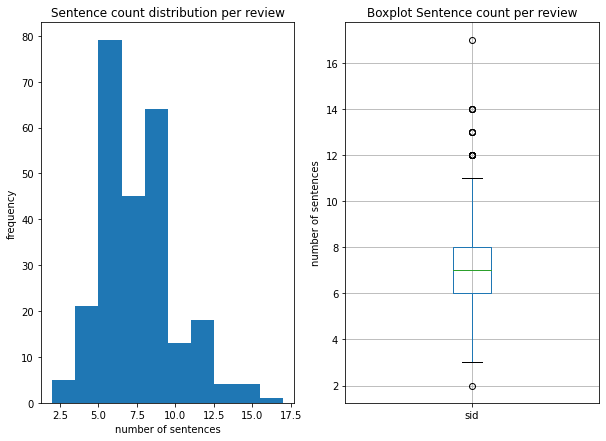

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(10,7))
df.groupby("rid").count()['sid'].plot.hist(ax=axes[0])
df.groupby("rid").count().boxplot(column=['sid'],ax=axes[1])
axes[0].set_title("Sentence count distribution per review")
axes[1].set_title("Boxplot Sentence count per review")
axes[0].set_xlabel('number of sentences')
axes[0].set_ylabel('frequency')
axes[1].set_ylabel('number of sentences')
plt.savefig("sentences_distribution.png")

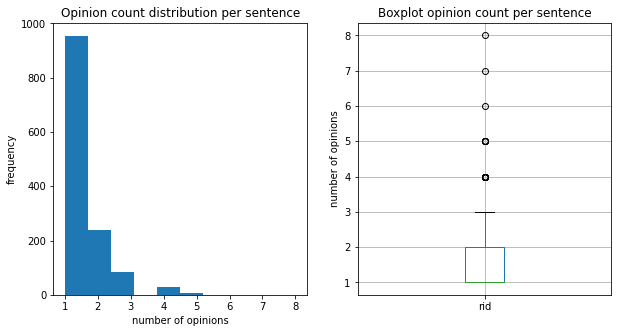

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(10,5))
df.groupby("sid").count()['rid'].plot.hist(ax=axes[0])
df.groupby("sid").count().boxplot(column=['rid'],ax=axes[1])
axes[0].set_title("Opinion count distribution per sentence")
axes[1].set_title("Boxplot opinion count per sentence")
axes[0].set_xlabel('number of opinions')
axes[0].set_ylabel('frequency')
axes[1].set_ylabel('number of opinions')
plt.savefig("opinions_distribution.png")

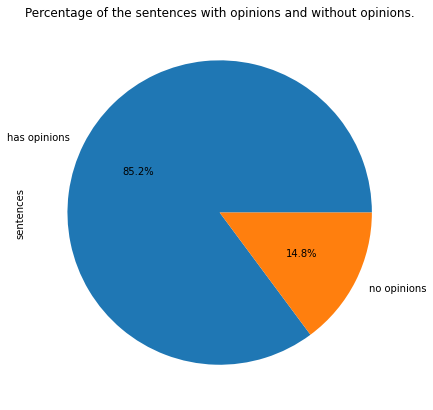

In [ ]:
tmp = df.groupby("sid").aggregate(list).reset_index()
tmp['sentences']=tmp['target'].apply(lambda x: 'no opinions' if np.nan in x else 'has opinions')
fig, ax = plt.subplots(figsize=(7,7))
tmp['sentences'].value_counts().plot.pie(ax=ax, autopct="%.1f%%");
plt.title("Percentage of the sentences with opinions and without opinions.")
plt.savefig("sentence_wo_opinions.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1654


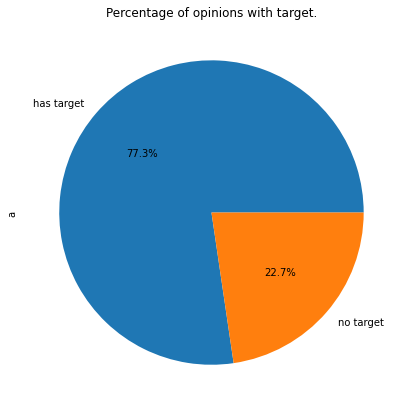

In [ ]:
tmp = df[df['f']=='yes']
tmp['a']=tmp['target'].apply(lambda x: 'no target' if 'NULL' in x else 'has target')
fig, ax = plt.subplots(figsize=(7,7))
tmp['a'].value_counts().plot.pie(ax=ax, autopct="%.1f%%");
plt.title("Percentage of opinions with target.")
plt.savefig("target_opinions.png")
print(tmp.shape[0])

**Cartesian product of the categories+polarities**

In [ ]:
import itertools
categories = set(df[df['category'].notna()]['category'].values)
polarities = set(df[df['polarity'].notna()]['polarity'].values)
cat_pol_couples = set(list(itertools.product(categories,polarities)))
print(len(cat_pol_couples))

39


In [ ]:
cat_pol_couples

{('AMBIENCE#GENERAL', 'negative'),
 ('AMBIENCE#GENERAL', 'neutral'),
 ('AMBIENCE#GENERAL', 'positive'),
 ('DRINKS#PRICES', 'negative'),
 ('DRINKS#PRICES', 'neutral'),
 ('DRINKS#PRICES', 'positive'),
 ('DRINKS#QUALITY', 'negative'),
 ('DRINKS#QUALITY', 'neutral'),
 ('DRINKS#QUALITY', 'positive'),
 ('DRINKS#STYLE_OPTIONS', 'negative'),
 ('DRINKS#STYLE_OPTIONS', 'neutral'),
 ('DRINKS#STYLE_OPTIONS', 'positive'),
 ('FOOD#GENERAL', 'negative'),
 ('FOOD#GENERAL', 'neutral'),
 ('FOOD#GENERAL', 'positive'),
 ('FOOD#PRICES', 'negative'),
 ('FOOD#PRICES', 'neutral'),
 ('FOOD#PRICES', 'positive'),
 ('FOOD#QUALITY', 'negative'),
 ('FOOD#QUALITY', 'neutral'),
 ('FOOD#QUALITY', 'positive'),
 ('FOOD#STYLE_OPTIONS', 'negative'),
 ('FOOD#STYLE_OPTIONS', 'neutral'),
 ('FOOD#STYLE_OPTIONS', 'positive'),
 ('LOCATION#GENERAL', 'negative'),
 ('LOCATION#GENERAL', 'neutral'),
 ('LOCATION#GENERAL', 'positive'),
 ('RESTAURANT#GENERAL', 'negative'),
 ('RESTAURANT#GENERAL', 'neutral'),
 ('RESTAURANT#GENERAL', 'po

**Dataset augmentation with all possible combination of category and polarities different from the one with the values.**

In [ ]:
# Dataset augmentation with all possible combination of category and polarities different from the one with the values.
grouped_by_sid = df.groupby('sid').agg(list).reset_index()
new_rows = []
for index, row in grouped_by_sid.iterrows():
  cats = row['category']
  pols = row['polarity']
  current_list = set()
  if len(cats)>0 and (np.nan not in cats):
    for (i,c) in enumerate(cats):
      current_list.add((cats[i],pols[i]))
  for (newc,newpol) in cat_pol_couples.difference(current_list): # nuovi da aggiungere
    new_row = {'rid':row['rid'][0],'sid':row['sid'],'txt':row['txt'][0],'OOTS':'False','target':np.nan,'category':newc,'polarity':newpol,'from':0,'to':0,'f':'no'}
    new_rows.append(new_row)

In [ ]:
augmented_dataset_part = pd.DataFrame(new_rows)
df = pd.concat([df,augmented_dataset_part])
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#PRICES,neutral,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#QUALITY,negative,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#MISCELLANEOUS,positive,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,negative,0,0


In [ ]:
df = df[df['category'].notna()] #this is needed because we already have inserted all the category combinatios also for no opinions reviews.
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#PRICES,neutral,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#QUALITY,negative,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#MISCELLANEOUS,positive,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,negative,0,0


**Distribution of opinions over sentences**

In [ ]:
df['f'].value_counts()

no     49780
yes     1654
Name: f, dtype: int64

In [ ]:
df.groupby('sid').agg(len).reset_index()['category'].value_counts()

39    1205
40      84
41      18
42       5
43       2
45       1
Name: category, dtype: int64

**Special character identification**

In [ ]:
#special_caracters = [1012, 1010, 1029, 999, 1024] #in order .,?!:
special_caracters = ['.',',','?','!'] #in order .,?!:
intersection = lambda x: list(set.intersection(set(x),set(special_caracters)))
word = "this is a differentiator.,?!:"
print(slow_tokenizer.tokenize(word))
print(slow_tokenizer(word))

['this', 'is', 'a', 'different', '##ia', '##tor', '.', ',', '?', '!', ':']
{'input_ids': [101, 2023, 2003, 1037, 2367, 2401, 4263, 1012, 1010, 1029, 999, 1024, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
t="ao,"
len(t.replace("#",""))

3

**New algorithm for BIO tagging**

In [ ]:
import re
cleanString = lambda x: re.sub('\W+','',x)
list_of_tagging_list = []

for index, row in df.iterrows():
  tagging_list = []
  if row['f'] == 'yes':
    txt = row['txt'].split(' ')        # We split the sentence in words with ' ' spaces.
    targets = row['target'].split(' ') # Target:'food pasta pizza'.
    from_ = int(row['from'])
    to = int(row['to']) 
    position = 0
    old_tag = 'O'
    for w in txt:
      tokens = slow_tokenizer.tokenize(w) # We get the token for each word for istance: differentiator, -> ['different', '##ia', '##tor',',']
      for t in tokens: #for each token
        position+=len(t.replace("#",""))
        if position-len(t.replace("#",""))>=from_ and position<=to:
          if old_tag == 'O':
            tagging_list.extend(['B'])
          elif old_tag == 'B':
            tagging_list.extend(['I'])
          else:
            tagging_list.extend(['I'])
        else:
          tagging_list.extend(['O'])
      position+=1 #space
      old_tag = tagging_list[-1]
    token_all_phrase = slow_tokenizer.tokenize(row['txt'])
    # print("txt: {} targets:{} tokens:{} tagging: {} correct: {}".format(txt,targets,token_all_phrase,tagging_list,len(token_all_phrase)==len(tagging_list))) 
  else:
    len_tokens = len(slow_tokenizer.tokenize(row['txt'])) # tags all O
    tagging_list.extend(['O']*len_tokens)
      
  list_of_tagging_list.append(tagging_list)
df['tagging'] = list_of_tagging_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Check if there are some opinions with Target but without any 'B' in the tagging.
tmp = df[df['target'].notna()]
tmp = tmp[tmp['target']!="NULL"]
sum=0
for i,row in tmp.iterrows():
  if 'B' in row['tagging']:
    sum+=1
  else:
    print("txt:{} tagging:{}".format(row["txt"],row['tagging']))
print(sum)

1279


**New column with category+polarity for the input.**

In [ ]:
#add the category column with the polarity.
list_aspects=[]
for i,row in df.iterrows():
  categ=None
  categ = (row["category"].lower()).split('#')
  new_text = categ[0]+" "+categ[1]+" "+row['polarity']
  list_aspects.append(new_text)
df['categ_txt'] = list_aspects
df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rid,sid,txt,OOTS,f,target,category,polarity,from,to,tagging,categ_txt
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56,"[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...",restaurant general negative
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general negative
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general negative
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",food quality negative
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B, O, O]",food style_options negative
...,...,...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,DRINKS#STYLE_OPTIONS,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",drinks style_options negative
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,neutral,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",service general neutral
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,positive,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",restaurant general positive
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,negative,0,0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",restaurant general negative


In [ ]:
def merge_tagging(tags_list): # For each (text, category) the targets do not overlapp
  result = []
  if len(tags_list)==1:
    return tags_list[0]
  for i in range(len(tags_list[0])):
    for t in tags_list:
      val="O"
      if t[i] == "B" or t[i] == "I":
        val = t[i]
        break
      else:
        val = "O"
    result.append(val)
  return result

In [ ]:
tagging_frame = df.groupby(["txt", "categ_txt"]).agg(list).reset_index()[['txt','categ_txt','f','tagging']]
tagging_frame['tagging']= tagging_frame['tagging'].apply(lambda x: merge_tagging(x))
tagging_frame['f']= tagging_frame['f'].apply(lambda x: "yes" if "yes" in x else "no")
tagging_frame

,txt,categ_txt,f,tagging
0,$20 for all you can eat sushi cannot be beaten.,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,ambience general neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,$20 for all you can eat sushi cannot be beaten.,ambience general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,$20 for all you can eat sushi cannot be beaten.,drinks prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,$20 for all you can eat sushi cannot be beaten.,drinks prices neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
51202,wont come back again for sure!,restaurant prices neutral,no,"[O, O, O, O, O, O, O, O]"
51203,wont come back again for sure!,restaurant prices positive,no,"[O, O, O, O, O, O, O, O]"
51204,wont come back again for sure!,service general negative,no,"[O, O, O, O, O, O, O, O]"
51205,wont come back again for sure!,service general neutral,no,"[O, O, O, O, O, O, O, O]"


In [ ]:
tagging_frame[tagging_frame['txt']=="Good spreads, great beverage selections and bagels really tasty."]

In [ ]:
#Number of rows with a target in the tagging sequence.
sum=0
for i,row in tagging_frame.iterrows():
  if 'B' in row['tagging']:
    sum+=1
print(sum)

1137


In [ ]:
tagging_frame[tagging_frame['f']=="yes"]

,txt,categ_txt,f,tagging
17,$20 for all you can eat sushi cannot be beaten.,food prices positive,yes,"[O, O, O, B, I, I, I, I, I, O, O, O, O]"
56,"$6 and there is much tasty food, all of it fre...",food prices positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
59,"$6 and there is much tasty food, all of it fre...",food quality positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
62,"$6 and there is much tasty food, all of it fre...",food style_options positive,yes,"[O, O, O, O, O, O, O, O, B, O, O, O, O, O, O, ..."
164,(Always ask the bartender for the SEASONAL bee...,drinks quality positive,yes,"[O, O, O, O, O, O, O, B, I, O, O, O]"
...,...,...,...,...
50994,too large for just two people but nothing was ...,food style_options negative,yes,"[O, O, O, O, O, O, O, O, O, O, O]"
51041,we love th pink pony.,restaurant general positive,yes,"[O, O, O, B, I, O]"
51117,"well, i didn't find it there, and trust, i hav...",restaurant general negative,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
51131,"whoever the jazz duo was, they were on POINT.",ambience general positive,yes,"[O, O, B, I, O, O, O, O, O, O, O]"


**Preparing dataset for the model**

In [ ]:
df = tagging_frame
df

,txt,categ_txt,f,tagging
0,$20 for all you can eat sushi cannot be beaten.,ambience general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,$20 for all you can eat sushi cannot be beaten.,ambience general neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,$20 for all you can eat sushi cannot be beaten.,ambience general positive,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,$20 for all you can eat sushi cannot be beaten.,drinks prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,$20 for all you can eat sushi cannot be beaten.,drinks prices neutral,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...
51202,wont come back again for sure!,restaurant prices neutral,no,"[O, O, O, O, O, O, O, O]"
51203,wont come back again for sure!,restaurant prices positive,no,"[O, O, O, O, O, O, O, O]"
51204,wont come back again for sure!,service general negative,no,"[O, O, O, O, O, O, O, O]"
51205,wont come back again for sure!,service general neutral,no,"[O, O, O, O, O, O, O, O]"


**Convering string values in integers**

In [ ]:
# convert yes,no in 0,1
# convert BIOP -> 0,1,2,3

**Dataset balancing**

In [ ]:
from sklearn.utils import shuffle
df_yes = df[df['f']=="yes"]
df_no = df[df['f']=="no"]
df_yes = shuffle(df_yes)
df_no = shuffle(df_no)

counts=df_yes['categ_txt'].value_counts().values.tolist()
cat_nums=[(v,counts[i]) for i,v in enumerate(df_yes['categ_txt'].value_counts().index.tolist())]
df_no_balanced = pd.DataFrame([],columns=df_yes.columns)
for c,num in cat_nums:
  selected=df_no[df_no['categ_txt']==c]
  selected=shuffle(selected)
  selected=selected.iloc[:num]
  df_no_balanced=pd.concat([df_no_balanced,selected])

df=pd.concat([df_yes, df_no_balanced])
df = shuffle(df)
df

,txt,categ_txt,f,tagging
48887,fine dining restaurant quality.,food quality positive,yes,"[O, B, O, O, O]"
2669,And it all comes at a very reasonable price (c...,food prices positive,yes,"[O, O, O, O, O, O, O, O, O, O, B, B, O, B, O, ..."
26402,Probably would not go again...,service general positive,no,"[O, O, O, O, O, O, O, O]"
3234,"As we were leaving, the couple standing by the...",service general negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7166,Everytime I decide to try another place on the...,restaurant general positive,yes,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
7448,Fantastic!,service general positive,no,"[O, O]"
28563,Steamed fresh so brought hot hot hot to your t...,food prices negative,no,"[O, O, O, O, O, O, O, O, O, O, O]"
31296,"The food however, is what one might expect.",food quality negative,yes,"[O, B, O, O, O, O, O, O, O, O]"
15317,I plan on stopping by next week as well.,restaurant general positive,yes,"[O, O, O, O, O, O, O, O, O, O]"


In [ ]:
# df.to_pickle("/content/drive/MyDrive/HLT/ds.pkl")

# Analysis


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/HLT/ds.pkl")

In [ ]:
df.head()

,txt,categ_txt,f,tagging
12081,"I choose to go with one of the special, the br...",restaurant miscellaneous negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
47804,You can't go wrong here.,restaurant general positive,yes,"[O, O, O, O, O, O, O, O]"
31176,The food can get pricey but the prixe fixe tas...,food prices negative,yes,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
49548,i've been to sapphire twice and both times the...,food quality negative,no,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
24317,Not enough wines by the glass either.,food quality positive,no,"[O, O, O, O, O, O, O, O]"


In [ ]:
df['pol'] = df.apply(lambda row: row.categ_txt.split(" ")[-1], axis=1)
df['tag_len'] = df.apply(lambda row: len(row.tagging), axis=1)
df['categ'] = df.apply(lambda row: ' '.join(row.categ_txt.split(" ")[:-1]), axis=1)

In [ ]:
count=df[df['f']=='yes'][['categ','pol']].value_counts().reset_index()

In [ ]:
#size of the opinions with a category
df[df['f']=='yes'].shape

(1504, 7)

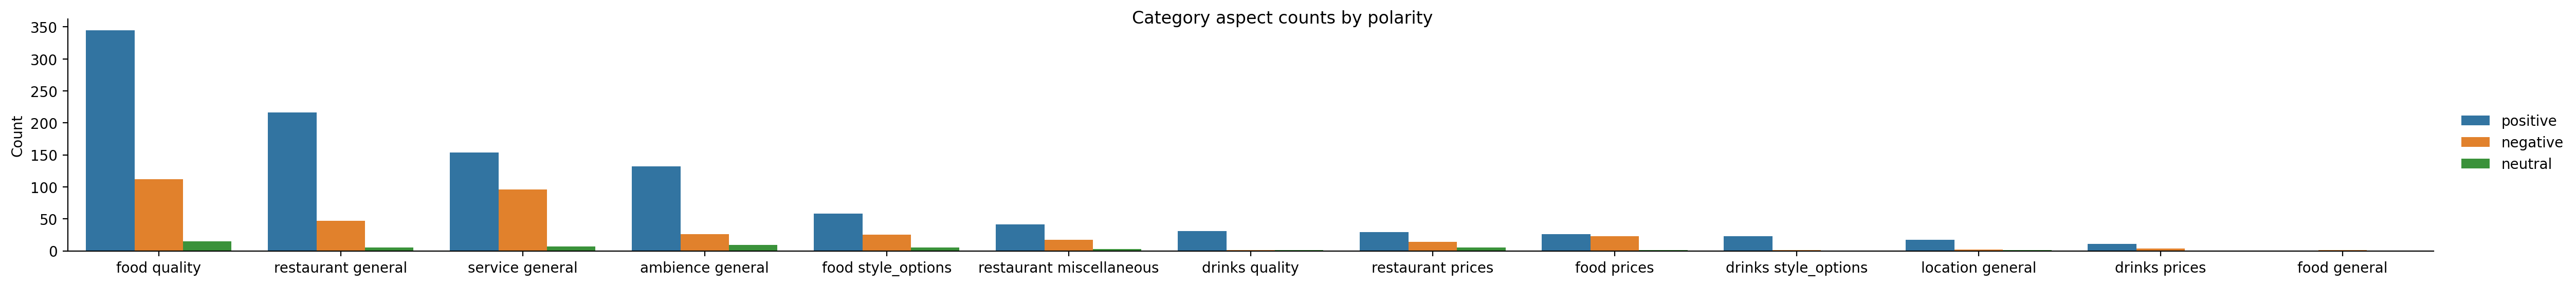

In [ ]:
import seaborn as sns
g = sns.catplot(
    data=count, kind="bar",  x="categ", y=0, hue="pol", height=3, aspect=8
)
g.fig.set_dpi(200)
g.despine()
g.set_axis_labels("", "Count")
g.legend.set_title("")
g.fig.suptitle('Category aspect counts by polarity')
plt.savefig('cat_counts.png')

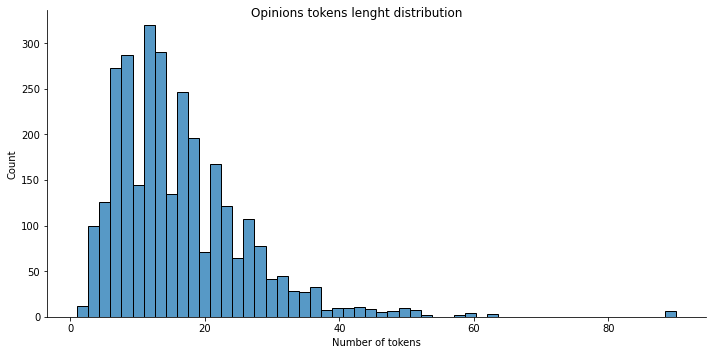

In [ ]:
p=sns.displot(df, x="tag_len", aspect=2)
p.set_axis_labels("Number of tokens", "Count")
p.fig.suptitle("Opinions tokens lenght distribution")
plt.savefig("op_tokens_len.png")

min:1 max:90 avg:16.232712765957448


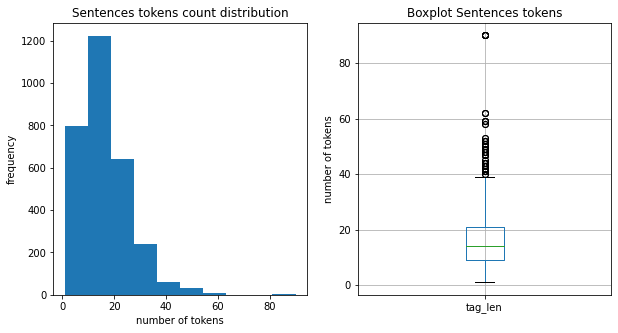

In [ ]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,2,figsize=(10,5))
df['tag_len'].plot.hist(ax=axes[0])
df.boxplot(column=['tag_len'],ax=axes[1])
axes[0].set_title("Sentences tokens count distribution")
axes[1].set_title("Boxplot Sentences tokens")
axes[0].set_xlabel('number of tokens')
axes[0].set_ylabel('frequency')
axes[1].set_ylabel('number of tokens')
plt.savefig("op_tokens_len.png")
print("min:{} max:{} avg:{}".format(df['tag_len'].min(),df['tag_len'].max(),df['tag_len'].mean()))

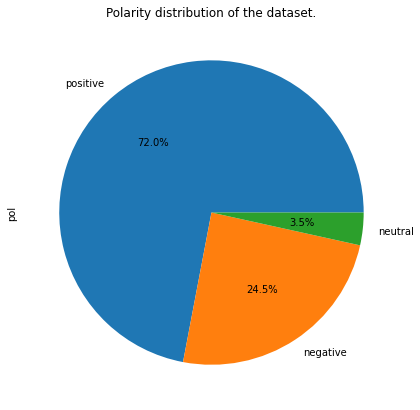

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
df['pol'].value_counts().plot.pie(ax=ax, autopct="%.1f%%");
plt.title("Polarity distribution of the dataset.")
plt.savefig("polarity_distribution.png")

# Just Aspects

In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 4.4 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 237 kB 62.7 MB/s 
     |████████████████████████████████| 1.1 MB 50.7 MB/s 
     |████████████████████████████████| 636 kB 51.9 MB/s 
     |████████████████████████████████| 1.2 MB 42.8 MB/s 
     |████████████████████████████████| 92 kB 7.3 MB/s 
     |████████████████████████████████| 352 kB 58.5 MB/s 
     |████████████████████████████████| 47.8 MB 2.3 MB/s 
     |████████████████████████████████| 99 kB 8.8 MB/s 


In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
# from official.nlp import optimization

max_len=266
query_len=10
max_len_txt=max_len-query_len

In [ ]:
import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/HLT/ds.pkl")

In [ ]:
#For loading hub layers from HUB in TPUs
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

In [ ]:
epochs=3
def create_model_class():
    ## BERT encoder
    #encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,0]
    # ['pooler_output']
    embedding = layers.Dropout(0.1)(embedding)
    l = layers.Dense(32, activation="tanh")(embedding)
    # output = layers.Dense(1, activation='sigmoid')(l)
    output = layers.Dense(2, activation='softmax')(l)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output],
    )
    METRICS = [
              tf.keras.metrics.CategoricalAccuracy(),
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall()
    ]
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()    
    steps_per_epoch = df.shape[0]
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    """optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')"""
    # model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

    return model

In [ ]:
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model_class()
else:
    model = create_model_class()
    
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.12.21.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.21.138:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 266)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 266)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 266)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_9[0][0]',          

In [ ]:
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  f = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)
    f.append(1 if row['f']=='yes' else 0)          
  x = [
      tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags,dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f,dtype=np.dtype('i')),dtype=tf.dtypes.int32)

no     1504
yes    1504
Name: f, dtype: int64

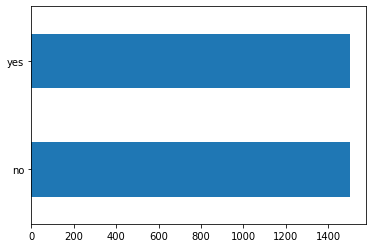

In [ ]:
df['f'].value_counts().sort_values().plot(kind = 'barh')
df['f'].value_counts()

In [ ]:
# x_train, y_train, val_x, val_y = create_ds()
x_train, y_train_t, y_train = create_inputs_targets()

In [ ]:
bs=8
epochs = 3
"""history = model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)"""
history = model.fit(x=x_train, y=y_train,
                    validation_split=0.1, batch_size=bs,
                               epochs=epochs)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


339/339 [==============================] - 142s 125ms/step - loss: 0.4940 - accuracy: 0.7606 - val_loss: 0.4017 - val_accuracy: 0.8538
Epoch 2/3
339/339 [==============================] - 31s 93ms/step - loss: 0.2670 - accuracy: 0.8932 - val_loss: 0.4445 - val_accuracy: 0.8272
Epoch 3/3
339/339 [==============================] - 31s 93ms/step - loss: 0.1470 - accuracy: 0.9512 - val_loss: 0.4240 - val_accuracy: 0.8870


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


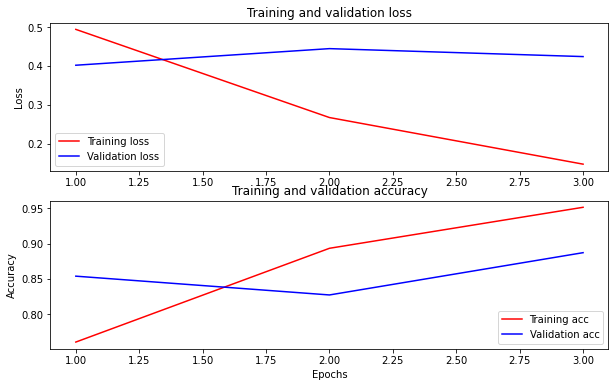

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Inference**

In [ ]:
#Inference
# c=("The pizza was very good but the service wasn't.","food quality positive")
# c=("The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing.", "food quality positive")
c=("The spaghetti were very tasty.","food quality positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = model.predict(x)
out

array([[0.00980832, 0.99019176]], dtype=float32)

In [ ]:
# model.save("/content/drive/MyDrive/HLT/class_model_balanced.h5")

# Just Entity recognition

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

max_len=266
query_len=10
max_len_txt=max_len-query_len

In [ ]:
import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/HLT/ds.pkl")

In [ ]:
ex = ("Not impressed with the food.","food quality negative")
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct
len(tokenize_couple(ex)['input_ids'])

266

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)          
  x = [
      tf.convert_to_tensor(np.array(input_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags,dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
x_train, y_train = create_inputs_targets()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)


def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,:max_len_txt-1,:]
    embedding = layers.Dropout(0.2)(embedding)
    l = layers.Dense(32,activation="tanh")(embedding)
    tag_logits = layers.Dense(num_tags, activation='softmax')(l)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=['accuracy'])
    return model

In [ ]:
def our_accuracy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.int32, name=None)
  y_pred = tf.cast(y_pred, tf.int32, name=None)
  mask = tf.math.logical_not(tf.math.equal(y_true, 3))
  total_no_padding = tf.reduce_sum(tf.cast(mask, tf.int32))
  mask = tf.cast(mask, dtype=tf.int32)
  # argmax_out = np.argmax(y_pred,-1)
  argmax_out = tf.math.argmax(
    y_pred,
    axis=-1,
    output_type=tf.dtypes.int32,
    name=None
  )
  print(y_true)
  print(mask)
  y_true *= mask
  argmax_out *= mask
  elements_equal_to_value = tf.equal(y_true, argmax_out)
  as_ints = tf.cast(elements_equal_to_value, tf.int32)
  count = tf.reduce_sum(as_ints)
  res = (count-(tf.size(y_true)-total_no_padding))/total_no_padding
  return res

In [ ]:
num_tags = 4 # BIOP
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(num_tags)
else:
    model = create_model(num_tags)
    
model.summary()

In [ ]:
bs = 16
# bs=8

model.fit(
    x_train,
    y_train,
    epochs=2,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)

Epoch 1/2


170/170 [==============================] - 126s 167ms/step - loss: nan - accuracy: 0.0678 - val_loss: nan - val_accuracy: 0.0716
Epoch 2/2
170/170 [==============================] - 16s 93ms/step - loss: nan - accuracy: 0.0689 - val_loss: nan - val_accuracy: 0.0722


**Inference**

In [ ]:
c=("The pizza was very good but the service wasn't.","food quality negative")
# c=("The spaghetti were very tasty.","food general positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = model.predict(x)
out = np.array(out)
argmax_out = np.argmax(out,-1)
tag_list = ["O","B","I","P"]
for i,t in enumerate(slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")):
  print("{}-{} ".format(t,tag_list[argmax_out[0][i]]))

[CLS]-O 
the-O 
pizza-O 
was-O 
very-O 
good-O 
but-O 
the-O 
service-B 
wasn-O 
'-O 
t-O 
.-O 
[SEP]-O 


**Save the model**

In [ ]:
# model.save("/content/drive/MyDrive/HLT/ner_model_balanced.h5")

# Final model

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

max_len=266
query_len=10
max_len_txt=max_len-query_len

import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/HLT/ds.pkl")

In [ ]:
def tokenize_couple(ex):
  dct=slow_tokenizer(ex[0], max_length=max_len_txt, padding='max_length')
  dct2=slow_tokenizer(ex[1]+"[SEP]",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  f = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)
    f.append(1 if row['f']=='yes' else 0)          
  x = [
      tf.convert_to_tensor(np.array(input_ids[100:]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids[100:]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask[100:]), dtype=tf.dtypes.int32),
  ]
  x_val = [      
      tf.convert_to_tensor(np.array(input_ids[:100]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids[:100]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask[:100]), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags[100:],dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f[100:],dtype=np.dtype('i')),dtype=tf.dtypes.int32), x_val, tf.convert_to_tensor(np.array(tags[:100],dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f[:100],dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
x_train, y_train_t, y_train_f, x_valid, y_valid_t, y_valid_f = create_inputs_targets()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    #encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    out = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )
    embedding=out['pooler_output']    
    embedding = layers.Dropout(0.1)(embedding)
    l = layers.Dense(16, activation="tanh")(embedding)
    output = layers.Dense(2, activation='softmax',name="category_output")(l)

    ner_embedding=out['last_hidden_state'][:,:max_len_txt-1,:]    
    ner_embedding = layers.Dropout(0.1)(ner_embedding)
    ner_l = layers.Dense(16, activation="tanh")(ner_embedding)
    ner_output = layers.Dense(num_tags, activation='softmax',name="ner_output")(ner_l)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output,ner_output],
    )

    losses = {
	    "category_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	    "ner_output": masked_ce_loss,
    }
    lossWeights = {"category_output": 1.0, "ner_output": 1.0}

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=losses, loss_weights=lossWeights,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

    return model

In [ ]:
num_tags = 4 # BIOP
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        final_model = create_model(num_tags)
else:
    final_model = create_model(num_tags)
    
tf.keras.utils.plot_model(final_model)

NameError: ignored

In [ ]:
bs = 16
# bs=8

final_model.fit(
    x=x_train,
    y={"category_output":y_train_f, "ner_output":y_train_t},
    # y=y_train_f,
    validation_data=(x_valid,
		{"category_output": y_valid_f, "ner_output": y_valid_t}),
    epochs=3,
    verbose=1,
    batch_size=bs
)

Epoch 1/3
182/182 [==============================] - 134s 167ms/step - loss: nan - category_output_loss: 0.5525 - ner_output_loss: nan - category_output_accuracy: 0.7160 - ner_output_accuracy: 0.0717 - val_loss: nan - val_category_output_loss: 0.5499 - val_ner_output_loss: nan - val_category_output_accuracy: 0.7500 - val_ner_output_accuracy: 0.0630
Epoch 2/3
182/182 [==============================] - 18s 99ms/step - loss: nan - category_output_loss: 0.3467 - ner_output_loss: nan - category_output_accuracy: 0.8566 - ner_output_accuracy: 0.0686 - val_loss: nan - val_category_output_loss: 0.4290 - val_ner_output_loss: nan - val_category_output_accuracy: 0.8200 - val_ner_output_accuracy: 0.0631
Epoch 3/3
182/182 [==============================] - 18s 99ms/step - loss: nan - category_output_loss: 0.2000 - ner_output_loss: nan - category_output_accuracy: 0.9298 - ner_output_accuracy: 0.0687 - val_loss: nan - val_category_output_loss: 0.4548 - val_ner_output_loss: nan - val_category_output_ac

In [ ]:
#Inference
c=("The waiter was attentive, the food was delicious and the views of the city were great.","food general positive")
# c=("The pasta were very tasty.","food quality positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = final_model.predict(x)
print(out[0])
argmax_out = np.argmax(out[1],-1)
tag_list = ["O","B","I","P"]
for i,t in enumerate(slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")):
  print("{}-{} ".format(t,tag_list[argmax_out[0][i]]))

[[0.02532563 0.9746743 ]]
[CLS]-O 
the-O 
waiter-O 
was-O 
at-O 
##ten-O 
##tive-O 
,-O 
the-O 
food-B 
was-O 
delicious-O 
and-O 
the-O 
views-O 
of-O 
the-O 
city-O 
were-O 
great-O 
.-O 
[SEP]-O 


# ROBERTA

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

max_len=200
query_len=10
max_len_txt=max_len-query_len

import pandas as pd
df = pd.read_pickle("/content/drive/MyDrive/HLT/ds.pkl")

In [ ]:
!pip install transformers
from transformers import RobertaTokenizer, TFRobertaModel
import tensorflow as tf

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# model = TFRobertaModel.from_pretrained("roberta-base")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def tokenize_couple(ex):
  dct=tokenizer(ex[0], max_length=max_len_txt, padding='max_length',add_special_tokens=True)
  dct2=tokenizer("</s>"+ex[1]+"</s>",add_special_tokens=False,max_length=query_len, padding='max_length')
  dct['token_type_ids'] = [0]* max_len_txt
  dct2['token_type_ids']=[1 for i in range(query_len)]
  dct['input_ids'].extend(dct2['input_ids'])
  dct['token_type_ids'].extend(dct2['token_type_ids'])
  dct['attention_mask'].extend(dct2['attention_mask'])
  return dct

In [ ]:
def create_inputs_targets():
  input_ids= []
  token_type_ids= []
  attention_mask= []
  tags = []
  f = []
  for i, row in df.iterrows():
    dic = tokenize_couple((row['txt'],row['categ_txt']))
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len_txt-len(tagging)-1))
    input_ids.append(dic['input_ids'])
    token_type_ids.append(dic['token_type_ids'])
    attention_mask.append(dic['attention_mask'])
    tags.append(tagging)
    f.append(1 if row['f']=='yes' else 0)          
  x = [
      tf.convert_to_tensor(np.array(input_ids[100:]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids[100:]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask[100:]), dtype=tf.dtypes.int32),
  ]
  x_val = [      
      tf.convert_to_tensor(np.array(input_ids[:100]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(token_type_ids[:100]), dtype=tf.dtypes.int32),
      tf.convert_to_tensor(np.array(attention_mask[:100]), dtype=tf.dtypes.int32),
  ]
  return x, tf.convert_to_tensor(np.array(tags[100:],dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f[100:],dtype=np.dtype('i')),dtype=tf.dtypes.int32), x_val, tf.convert_to_tensor(np.array(tags[:100],dtype=np.dtype('i')),dtype=tf.dtypes.int32), tf.convert_to_tensor(np.array(f[:100],dtype=np.dtype('i')),dtype=tf.dtypes.int32)

In [ ]:
x_train, y_train_t, y_train_f, x_valid, y_valid_t, y_valid_f = create_inputs_targets()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    #encoder
    encoder = TFRobertaModel.from_pretrained("roberta-base")
    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    out = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )
    embedding=out['pooler_output']    
    embedding = layers.Dropout(0.1)(embedding)
    l = layers.Dense(32, activation="tanh")(embedding)
    output = layers.Dense(2, activation='softmax',name="category_output")(l)

    ner_embedding=out['last_hidden_state'][:,:max_len_txt-1,:]    
    ner_embedding = layers.Dropout(0.1)(ner_embedding)
    # ner_l = layers.Dense(32, activation="tanh")(ner_embedding)
    ner_output = layers.Dense(num_tags, activation='softmax',name="ner_output")(ner_embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output,ner_output],
    )

    losses = {
	    "category_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
	    "ner_output": masked_ce_loss,
    }
    lossWeights = {"category_output": 1.0, "ner_output": 1.0}

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=losses, loss_weights=lossWeights,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

    return model

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.123.7.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.123.7.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


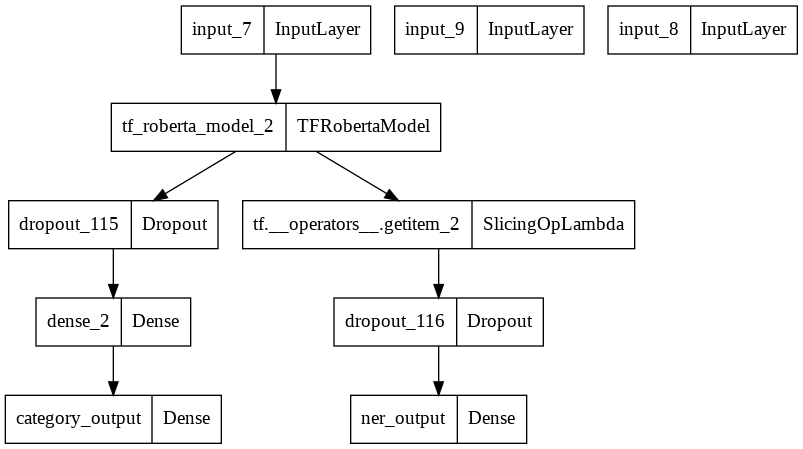

In [ ]:
num_tags = 4 # BIOP
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        final_model = create_model(num_tags)
else:
    final_model = create_model(num_tags)
    
tf.keras.utils.plot_model(final_model)

In [ ]:
bs = 8
# bs=8

final_model.fit(
    x=x_train,
    y={"category_output":y_train_f, "ner_output":y_train_t},
    # y=y_train_f,
    validation_data=(x_valid,
		{"category_output": y_valid_f, "ner_output": y_valid_t}),
    epochs=3,
    verbose=1,
    batch_size=bs
)

Epoch 1/3
364/364 [==============================] - 33s 92ms/step - loss: nan - category_output_loss: 0.6943 - ner_output_loss: nan - category_output_accuracy: 0.5062 - ner_output_accuracy: 0.0925 - val_loss: nan - val_category_output_loss: 0.6936 - val_ner_output_loss: nan - val_category_output_accuracy: 0.4500 - val_ner_output_accuracy: 0.0850
Epoch 2/3
364/364 [==============================] - 33s 92ms/step - loss: nan - category_output_loss: 0.6936 - ner_output_loss: nan - category_output_accuracy: 0.5072 - ner_output_accuracy: 0.0925 - val_loss: nan - val_category_output_loss: 0.6940 - val_ner_output_loss: nan - val_category_output_accuracy: 0.4500 - val_ner_output_accuracy: 0.0850
Epoch 3/3
364/364 [==============================] - 34s 94ms/step - loss: nan - category_output_loss: 0.6938 - ner_output_loss: nan - category_output_accuracy: 0.5010 - ner_output_accuracy: 0.0925 - val_loss: nan - val_category_output_loss: 0.6916 - val_ner_output_loss: nan - val_category_output_accu

In [ ]:
# final_model.save("/content/drive/MyDrive/HLT/jointed_roberta.h5")
# final_model.load_weights("/content/drive/MyDrive/HLT/jointed_roberta.h5")

In [ ]:
#Inference
c=("The waiter was attentive, the food was delicious and the views of the city were great.","food quality positive")
# c=("The pasta were very tasty.","food quality positive")
#c = ("There is something about their atmosphere that makes me come back nearly every week.","ambience general positive")
tokens=tokenize_couple(c)
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = final_model.predict(x)
print(out[0])
argmax_out = np.argmax(out[1],-1)
tag_list = ["O","B","I","P"]
for i,t in enumerate(tokenizer.tokenize("<s>"+c[0])):
  print("{}-{} ".format(t.replace("Ġ",""),tag_list[argmax_out[0][i]]))

[[0.4851598  0.51484025]]
<s>-O 
The-O 
waiter-O 
was-O 
attentive-O 
,-O 
the-O 
food-O 
was-O 
delicious-O 
and-O 
the-O 
views-O 
of-O 
the-O 
city-O 
were-O 
great-O 
.-O 


In [ ]:
import pickle
pkl_file = open('/content/drive/MyDrive/HLT/cat_pol_couples.pkl', 'rb')
cat_pol_couples = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
from functools import reduce

def inference_function(c,th):
  res=[]
  tokens=tokenize_couple(c)
  x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
  out = final_model.predict(x,verbose=0,)
  out1 = out[0]
  out2 = out[1]
  out1[out1 < th] = 0 #thresholding.
  indice = np.argmax(out1[0])
  classi=["no","yes"]
  # print(classi[indice])
  tag_couple = []
  category = "#".join(c[1].split(" ")[:-1])
  category = category.upper()
  if indice==1:
    argmax_out = np.argmax(out2,-1)
    if 1 in argmax_out:
      tag_list = ["O","B","I","P"]
      tokens = tokenizer.tokenize("<s>"+c[0])
      tokens=list(map(lambda x:x.replace('Ġ',''),tokens))
      for i,t in enumerate(tokens):
        tag_couple.append((t,tag_list[argmax_out[0][i]]))
        # print("{}-{}".format(t,tag_list[argmax_out[0][i]]))
      
      tokens = tokens[1:] #remove [CLS] and [SEP] tokens
      list_indices = []
      start=0
      end=0
      previous = 'O'
      trovato = False
      for i,(t,tag) in enumerate(tag_couple[1:]):
        if tag!='O' and not trovato:
          start=i
          trovato=True
        if trovato and tag=='O':
          end=i
          trovato=False
          list_indices.append((start,end))
      special_caracters=[':','-','$','[',']',')','(','.',',','?','!']
      for z in list_indices:
        parte_asx = tokens[:z[0]]
        if len(parte_asx)==0:
          from_= 0
          fake_space_sx = 0
        else:
          from_ = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_asx)))
          fake_space_sx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_asx)))
        space_sx = z[0]
        from_+=space_sx-fake_space_sx
        parte_adx = tokens[:z[1]]
        to = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_adx)))
        space_dx = z[1]
        fake_space_dx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_adx)))
        to+=space_dx-fake_space_dx-1
        # print("target={} category={} polarity={} from:{} to:{}".format(c[0][from_:to],"#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],from_,to))
        
        res.append({'target':c[0][from_:to], 'category':category, 'polarity':c[1].split(" ")[-1], 'from':str(from_), 'to':str(to)})
        # res+="<a style=\"font-size:13px\">target={} category={} polarity={} from:{} to:{}</a><br>".format(c[0][from_:to],"#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],from_,to)
    else:
      # print("target={} category={} polarity={} from:{} to:{}".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0))
      # res += "target={} category={} polarity={} from:{} to:{}".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0)
      res.append({'target':"NULL", 'category':category, 'polarity':c[1].split(" ")[-1], 'from':'0', 'to':'0'})
      # res+="<a style=\"font-size:13px\">target={} category={} polarity={} from:{} to:{}</a><br>".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0)
  return res


In [ ]:
inference_function(("The waiter was attentive, the food was delicious and the views of the city were great.","location quality positive"),0.90)

[{'category': 'LOCATION#QUALITY',
  'from': '4',
  'polarity': 'positive',
  'target': 'waiter',
  'to': '10'},
 {'category': 'LOCATION#QUALITY',
  'from': '57',
  'polarity': 'positive',
  'target': 'views',
  'to': '62'}]

In [ ]:
def big_inference(txt,th=0.90):
  res=[]
  for cat in cat_pol_couples:
    c = (txt," ".join(cat[0].lower().split("#"))+" "+cat[1])
    res += inference_function(c,th)
  return res

In [ ]:
# big_inference("The waiter was attentive, the food was delicious and the views of the city were great.")

In [ ]:
def get_opinions(txt, th=0.90):
  predict = [];
  
  for cat in cat_pol_couples:
    c = (txt," ".join(cat[0].lower().split("#"))+" "+cat[1])
    inf = inference_function(c,th)
    if len(inf)>0:
      predict.extend(inf)

  return predict

In [ ]:
import os

def jaccardIndex(predict, target):
  predict = list(map(str,predict))
  target = list(map(str,target))
  predict = set(predict)
  target = set(target)
  
  inter = len(predict.intersection(target))
  union = len(predict.union(target))
  if union==0:
    return 1
  return inter / union


def precision(predict, target):
  predict = list(map(str,predict))
  target = list(map(str,target))
  predict = set(predict)
  target = set(target)
  
  inter = len(predict.intersection(target))
  num_predict = len(predict)
  if num_predict==0:
    return 1
  return inter / num_predict

def recall(predict, target):
  predict = list(map(str,predict))
  target = list(map(str,target))
  predict = set(predict)
  target = set(target)
  
  inter = len(predict.intersection(target))
  num_target = len(target)
  if num_target==0:
    return 1
  return inter / num_target

def f1score(predict, target):
  p=precision(predict, target)
  r=recall(predict, target)
  return (2 * p * r) / (p + r) if (p+r)>0 else 0

import zipfile
import pandas as pd
import xml.etree.ElementTree as ET

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTS.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
  zip_ref.extractall("./dataset")

In [ ]:
import numpy as np

def evaluate_restaurants():
  """
    Mean of Jaccard index over the sentences
  """

  xml_path = "/content/dataset/ABSA15_Restaurants_Test.xml"
  mytree = ET.parse(xml_path)
  reviews = mytree.getroot()
  input = []
  all_opinions = []
  for rew in reviews:
    for sent in rew[0]: #cicle on single sentence in review.
      txt = sent[0].text
      if len(sent)>1:
        input.append(txt)
        sent_opinions = []
        for opinion in sent[1]:
          op_dict = opinion.attrib
          sent_opinions.append(op_dict)
        all_opinions.append(sent_opinions)

  MJI = 0
  MPR = 0
  MRC = 0
  MF1 = 0
  tot = len(input)
  i = 0
  for sent_txt, opinions_target in zip(input, all_opinions):
    predict = get_opinions(sent_txt)
    MJI += jaccardIndex(predict, opinions_target)
    MPR += precision(predict, opinions_target)
    MRC += recall(predict, opinions_target)
    MF1 += f1score(predict, opinions_target)
    i += 1
    print("Observed={}".format(i/tot))
    print("Jaccard={} Precision={} Recall={} F1-score={}".format(MJI/i,MPR/i,MRC/i,MF1/i))

  return MJI/tot, MPR/tot, MRC/tot, MF1/tot

In [ ]:
j,p,r,f1 = evaluate_restaurants()
print("Jaccard:{} Precision:{} Recall:{} F1:{}".format(j,p,r,f1))

# Inference of models

In [ ]:
import pandas as pd
import pickle

df = pd.read_pickle("/content/drive/MyDrive/HLT/ds.pkl")
pkl_file = open('/content/drive/MyDrive/HLT/cat_pol_couples.pkl', 'rb')
cat_pol_couples = pickle.load(pkl_file)
pkl_file.close()

In [ ]:
epochs=1
model = create_model_class()
model.load_weights("/content/drive/MyDrive/HLT/class_model_balanced.h5")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
ner_model = create_model(4)
ner_model.load_weights("/content/drive/MyDrive/HLT/ner_model_balanced.h5")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from functools import reduce

def inference_function(c,th):
  res=[]
  tokens=tokenize_couple(c)
  x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
  out2 = ner_model.predict(x,verbose=0,)
  out1 = model.predict(x,verbose=0,)
  out1[out1 < th] = 0 #thresholding.
  indice = np.argmax(out1[0])
  classi=["no","yes"]
  # print(classi[indice])
  tag_couple = []
  category = "#".join(c[1].split(" ")[:-1])
  category = category.upper()
  if indice==1:
    argmax_out = np.argmax(out2,-1)
    if 1 in argmax_out:
      tag_list = ["O","B","I","P"]
      tokens = slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")
      for i,t in enumerate(tokens):
        tag_couple.append((t,tag_list[argmax_out[0][i]]))
        # print("{}-{}".format(t,tag_list[argmax_out[0][i]]))
      
      tokens = tokens[1:-1] #remove [CLS] and [SEP] tokens
      list_indices = []
      start=0
      end=0
      previous = 'O'
      trovato = False

      for i,(t,tag) in enumerate(tag_couple[1:-1]):
        if tag!='O' and not trovato:
          start=i
          trovato=True
        if trovato and tag=='O':
          end=i
          trovato=False
          list_indices.append((start,end))
      special_caracters=[':','-','$','[',']',')','(','.',',','?','!']
      for z in list_indices:
        parte_asx = tokens[:z[0]]
        if len(parte_asx)==0:
          from_= 0
          fake_space_sx = 0
        else:
          from_ = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_asx)))
          fake_space_sx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_asx)))
        space_sx = z[0]
        from_+=space_sx-fake_space_sx
        parte_adx = tokens[:z[1]]
        to = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_adx)))
        space_dx = z[1]
        fake_space_dx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_adx)))
        to+=space_dx-fake_space_dx-1
        # print("target={} category={} polarity={} from:{} to:{}".format(c[0][from_:to],"#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],from_,to))
        
        res.append({'target':c[0][from_:to], 'category':category, 'polarity':c[1].split(" ")[-1], 'from':str(from_), 'to':str(to)})
        # res+="<a style=\"font-size:13px\">target={} category={} polarity={} from:{} to:{}</a><br>".format(c[0][from_:to],"#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],from_,to)
    else:
      # print("target={} category={} polarity={} from:{} to:{}".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0))
      # res += "target={} category={} polarity={} from:{} to:{}".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0)
      res.append({'target':"NULL", 'category':category, 'polarity':c[1].split(" ")[-1], 'from':'0', 'to':'0'})
      # res+="<a style=\"font-size:13px\">target={} category={} polarity={} from:{} to:{}</a><br>".format("NULL","#".join(c[1].split(" ")[:-1]),c[1].split(" ")[-1],0,0)
  return res


In [ ]:
c=("I LOOOVE their eggplant pizza, as well as their pastas and their risotti!","food quality positive")
# c = ("Good food: my favorite is the seafood spaghetti.","food quality positive")
inference_function(c,0.90)

[{'category': 'FOOD#QUALITY',
  'from': '15',
  'polarity': 'positive',
  'target': 'eggplant pizza',
  'to': '29'},
 {'category': 'FOOD#QUALITY',
  'from': '48',
  'polarity': 'positive',
  'target': 'pastas',
  'to': '54'},
 {'category': 'FOOD#QUALITY',
  'from': '65',
  'polarity': 'positive',
  'target': 'risotti',
  'to': '72'}]

In [ ]:
tokenize_couple(("I love the pizza here!","food quality positive"))

{'input_ids': [101, 1045, 2293, 1996, 10733, 2182, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2833, 3737, 3893, 102, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def big_inference(txt,th=0.90):
  res=""
  for cat in cat_pol_couples:
    c = (txt," ".join(cat[0].lower().split("#"))+" "+cat[1])
    res += inference_function(c,th)
  return res

In [ ]:
a = big_inference("The waiter was attentive, the food was delicious and the views of the city were great.")

target=food category=food#general polarity=positive from:30 to:34
target=waiter category=service#general polarity=positive from:4 to:10
target=food category=food#quality polarity=positive from:30 to:34
target=views category=ambience#general polarity=positive from:57 to:62
target=NULL category=location#general polarity=positive from:0 to:0


In [ ]:
a

'target=food category=food#general polarity=positive from:30 to:34 \ntarget=waiter category=service#general polarity=positive from:4 to:10 \ntarget=food category=food#quality polarity=positive from:30 to:34 \ntarget=views category=ambience#general polarity=positive from:57 to:62 \ntarget=NULL category=location#general polarity=positive from:0 to:0 \n'

##Gradio

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
demo = gr.Interface(
    fn=big_inference,
    inputs=["text"],
    outputs=["html"],
)
# gr.Slider(0, 1)
demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://42923.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


target=food category=food#general polarity=positive from:30 to:34
target=waiter category=service#general polarity=positive from:4 to:10
target=food category=food#quality polarity=positive from:30 to:34
target=views category=ambience#general polarity=positive from:57 to:62
target=NULL category=location#general polarity=positive from:0 to:0
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fc27f33aed0>,
 'http://127.0.0.1:7861/',
 'https://42923.gradio.app')

# Evaluation

In [ ]:
from functools import reduce

def inference_function(c,th):
  res=[]
  tokens=tokenize_couple(c)
  x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
  out2 = ner_model.predict(x,verbose=0,)
  out1 = model.predict(x,verbose=0,)
  out1[out1 < th] = 0 #thresholding.
  indice = np.argmax(out1[0])
  classi=["no","yes"]
  tag_couple = []
  category = "#".join(c[1].split(" ")[:-1])
  category = category.upper()
  if indice==1:
    argmax_out = np.argmax(out2,-1)
    if 1 in argmax_out:
      tag_list = ["O","B","I","P"]
      tokens = slow_tokenizer.tokenize("[CLS]"+c[0]+"[SEP]")
      for i,t in enumerate(tokens):
        tag_couple.append((t,tag_list[argmax_out[0][i]]))
      
      tokens = tokens[1:-1] #remove [CLS] and [SEP] tokens
      list_indices = []
      start=0
      end=0
      previous = 'O'
      trovato = False

      for i,(t,tag) in enumerate(tag_couple[1:-1]):
        if tag!='O' and not trovato:
          start=i
          trovato=True
        if trovato and tag=='O':
          end=i
          trovato=False
          list_indices.append((start,end))
      special_caracters=[':','-','$','[',']',')','(','.',',','?','!']
      for z in list_indices:
        parte_asx = tokens[:z[0]]
        if len(parte_asx)==0:
          from_= 0
          fake_space_sx = 0
        else:
          from_ = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_asx)))
          fake_space_sx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_asx)))
        space_sx = z[0]
        from_+=space_sx-fake_space_sx
        parte_adx = tokens[:z[1]]
        to = reduce(lambda x,y:x+y,(map(lambda x:len(x.replace("#","")),parte_adx)))
        space_dx = z[1]
        fake_space_dx = reduce(lambda x,y:x+y,(map(lambda x: 1 if ("#" in x) or (x in special_caracters) else 0,parte_adx)))
        to+=space_dx-fake_space_dx-1
        
        res.append({'target':c[0][from_:to], 'category':category, 'polarity':c[1].split(" ")[-1], 'from':str(from_), 'to':str(to)})
    else:

      res.append({'target':"NULL", 'category':category, 'polarity':c[1].split(" ")[-1], 'from':'0', 'to':'0'})
  return res

In [ ]:
def get_opinions(txt, th=0.90):
  predict = [];
  
  for cat in cat_pol_couples:
    c = (txt," ".join(cat[0].lower().split("#"))+" "+cat[1])
    inf = inference_function(c,th)
    if len(inf)>0:
      predict.extend(inf)

  return predict

In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def get_opinions_rawText(txt, th=0.90):
  ss = sent_tokenize(txt)

  predict = [];
  for s in ss:
    predict.append(get_opinions(s, th));

  return predict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
get_opinions_rawText("Hi, i'm chiara pugliese")

NameError: ignored

In [ ]:
import os

def jaccardIndex(predict, target):
  predict = list(map(str,predict))
  target = list(map(str,target))
  predict = set(predict)
  target = set(target)
  
  inter = len(predict.intersection(target))
  union = len(predict.union(target))
  if union==0:
    return 1
  return inter / union

In [ ]:
import os

def precision(predict, target):
  predict = list(map(str,predict))
  target = list(map(str,target))
  predict = set(predict)
  target = set(target)
  
  inter = len(predict.intersection(target))
  num_predict = len(predict)
  if num_predict==0:
    return 1
  return inter / num_predict

In [ ]:
import os

def recall(predict, target):
  predict = list(map(str,predict))
  target = list(map(str,target))
  predict = set(predict)
  target = set(target)
  
  inter = len(predict.intersection(target))
  num_target = len(target)
  if num_target==0:
    return 1
  return inter / num_target

In [ ]:
import os

def f1score(predict, target):
  return (2 * precision(predict, target) * recall(predict, target)) / (precision(predict, target) + recall(predict, target))

In [ ]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
!pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTS.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
  zip_ref.extractall("./dataset")

In [ ]:
import numpy as np

def evaluate_restaurants():
  """
    Mean of Jaccard index over the sentences
  """

  xml_path = "/content/dataset/ABSA15_Restaurants_Test.xml"
  mytree = ET.parse(xml_path)
  reviews = mytree.getroot()
  input = []
  all_opinions = []
  for rew in reviews:
    for sent in rew[0]: #cicle on single sentence in review.
      txt = sent[0].text
      if len(sent)>1:
        input.append(txt)
        sent_opinions = []
        for opinion in sent[1]:
          op_dict = opinion.attrib
          sent_opinions.append(op_dict)
        all_opinions.append(sent_opinions)

  JI = 0
  PR = 0
  RC = 0
  F1 = 0
  tot = len(input)
  i = 0
  for sent_txt, opinions_target in zip(input, all_opinions):
    predict = get_opinions(sent_txt)
    i += 1
    JI += jaccardIndex(predict, opinions_target)
    PR += precision(predict, opinions_target)
    RC += recall(predict, opinions_target)
    F1 += f1score(predict, opinions_target)
    print("Observed={}".format(i/tot))
    print("Jaccard={} Precision={} Recall={} F1-score={}".format(JI/i,PR/i,RC/i,F1/i))

  MJI = JI/tot
  MPR = PR/tot
  MRC = RC/tot
  MF1 = F1/tot

  return MJI,MPR,MRC,MF1

In [ ]:
j,p,r,f = evaluate_restaurants()
print("Jaccard:{} Precision:{} Recall:{} F1:{}".format(j,p,r,f))

0.0
J=0.0 P=0.0 R=0.0
0.001718213058419244
J=0.5 P=0.5 R=0.5
0.003436426116838488
J=0.5 P=0.5 R=0.6666666666666666
0.005154639175257732
J=0.5 P=0.5 R=0.75
0.006872852233676976
J=0.5 P=0.5 R=0.8
0.00859106529209622
J=0.44047619047619047 P=0.44047619047619047 R=0.8333333333333334
0.010309278350515464
J=0.401360544217687 P=0.401360544217687 R=0.8571428571428571
0.012027491408934709
J=0.35119047619047616 P=0.35119047619047616 R=0.75
0.013745704467353952
J=0.3677248677248677 P=0.3677248677248677 R=0.7777777777777778
0.015463917525773196
J=0.33095238095238094 P=0.33095238095238094 R=0.7
0.01718213058419244
J=0.3463203463203463 P=0.3463203463203463 R=0.7272727272727273
0.018900343642611683
J=0.35912698412698413 P=0.35912698412698413 R=0.75
0.020618556701030927
J=0.4084249084249084 P=0.4084249084249084 R=0.7692307692307693
0.022336769759450172
J=0.4149659863945578 P=0.4149659863945578 R=0.7857142857142857
0.024054982817869417
J=0.3873015873015873 P=0.45396825396825397 R=0.7333333333333333
0.02

In [ ]:
opinions = get_opinions("I recommend this place to everyone.")

In [ ]:
opinions

[{'category': 'RESTAURANT#GENERAL',
  'from': '17',
  'polarity': 'positive',
  'target': 'place',
  'to': '22'}]

In [ ]:
target = [{'target':"pastas", 'category':"FOOD#QUALITY", 'polarity':"positive", 'from':4, 'to':10},
{'target':"risottos", 'category':"FOOD#QUALITY", 'polarity':"positive", 'from':31, 'to':39},
{'target':"sepia", 'category':"FOOD#QUALITY", 'polarity':"positive", 'from':58, 'to':63},
{'target':"braised rabbit", 'category':"FOOD#QUALITY", 'polarity':"positive", 'from':87, 'to':101}]

In [ ]:
precision(opinions,target)

0.5